# Workflow
---
### New csv files moved into 'raw'
> * Read all together and remove duplicates

### Output csv to 'processed'
> * Contains all 'potential customers' 
> * Concatenate all together and remove duplicates

### Filter 
> * Select filters, append to database.

### Scrape check
> * Check landing page
> * IS or NOT godaddy landing page - append to database

### Email
> * If within area codes - send standard email
> * If not - randomise between remaining two

### Update
> * Customer database

In [117]:
# mount google drive if running in colab
import os
import sys

if os.path.exists('/usr/lib/python3.6/'):
    from google.colab import drive
    drive.mount('/content/drive/')
    sys.path.append('/content/drive/My Drive/Colab Notebooks/email_marketing/email_marketing')
    %cd /content/drive/My Drive/Colab Notebooks/email_marketing/email_marketing
else:
    sys.path.append('../../')

In [118]:
import numpy as np
import pandas as pd
import os
import joblib
import progressbar

# importing scripts
%load_ext autoreload
%autoreload 2
#%aimport src.data.make_dataset
#%aimport src.utilities.helper

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
import requests
import joblib
import pickle
import datetime
import re
import calendar
import json
import pandas as pd
import lxml
from bs4 import BeautifulSoup
import random
from IPython.core.display import HTML
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta
from datetime import datetime as dt
from IPython.core.display import HTML
import pprint
import glob
from pygeocoder import Geocoder
from email.mime.text import MIMEText
import smtplib
import progressbar
import os  
import shutil 

path = 'godaddy/'

### GoDaddy URL checker

In [120]:
def godaddy_checker(url):
    '''
    Returns True if url is godaddy landing page    
    
    '''
    url = 'http://' + url
    
    try:
        r = requests.get(url, timeout=20)
        soup = BeautifulSoup(r.content, 'html')
    except:
        return False
    try: 
        if 'parked-content.godaddy.com' in str(soup.find('iframe')):
            return True
        else:
            return False
    except:
        return False

### Load multiple csv files and clean

In [349]:
def load_csvs(files_location=path + "/*.csv"):
    '''
    Load all csvs in file location and concatenate, 
    Drops duplicates and non godaddy domains
    return df    
    '''
    
    drop_columns = ['num', 'query_time', 'update_date', 'expiry_date', 'registrant_fax',
                   'administrative_fax', 'technical_fax', 'billing_name',
                   'billing_company', 'billing_address', 'billing_city', 'billing_state',
                   'billing_zip', 'billing_country', 'billing_email', 'billing_phone',
                   'billing_fax', 'name_server_1', 'name_server_2', 'name_server_3',
                   'name_server_4', 'domain_status_1', 'domain_status_2',
                   'domain_status_3', 'domain_status_4']
    email_flag_list = ['whois', 'privacy', 'protect', 'admin', 'domain', 'support', 'proxy', 'secure', 'private', 'secure', 'proxy']
    name_drop_list = ['privacy', 'administrator', 'redacted', 'domain', 'not available', 'help desk', 'private', 
                      'department', 'registration', 'admin', 'holdings', 'self', 'web master', 'media', 'url manager'
                      'help desk', 'company', 'support', 'test', 'hostmaster', 'helpdesk', ' inc', 'protected', 'disclosed',
                      'gdpr masked', 'interactive', '1983', ' llp', 'group', 'llc', 'the ', 'corporation', 'USA', 'director',
                      'customer', 'saving', 'mortgage', 'management', 'scientific', 'government', 'international', 'broadcasting',
                      'manager', 'service', 'embassy', 'online', 'tax ', 'transportation', 'center', 'policy', 'hilton', 'building',
                      'service', '.com', ' ltd', 'computer', 'tech', 'market', 'partners', 'institute', 'network', 'business', 'leader',
                      'america', 'enterprise', 'solutions', 'investment', 'insurance', 'development', 'union', 'product', 'industries',
                      'venture', 'distribut', 'united', 'school', 'hospital', 'authority', ' usa', 'operation', 'catholic', 'united', 'world'
                      'global', 'design', 'research']

            
    all_files = glob.glob(files_location)
    files = []
    for filename in all_files:
        df = pd.read_csv(filename)
        files.append(df)
    df = pd.concat(files, axis=0, ignore_index=True)
    df.drop(drop_columns, axis=1, inplace=True)
    df.drop_duplicates(subset='domain_name', keep='first', ignore_index=True, inplace=True)
    df.dropna(subset=['registrant_email'], inplace=True)
    df.dropna(subset=['registrant_name'], inplace=True)
        
    if 'Unnamed: 0' in df.columns:
        df.drop('Unnamed: 0', axis=1, inplace=True)
    
    df = df[~df.registrant_email.str.lower().str.contains(('|'.join(email_flag_list)))]
    df = df[~df.registrant_name.str.lower().str.contains(('|'.join(name_drop_list)))]
    df = df[~df.registrant_name.str.isdigit()]
    df.reset_index(drop=True, inplace=True)
    
    email_list = [f'email{i}' for i in range(20)]
    for email in email_list:
        df[email] = 0
    df['landing'] = np.nan
        
    return df

In [350]:
df = load_csvs('godaddy/data/raw/*.zip')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


### Load new CSVs to
* load csvs in 'raw'
* appends to 'processed' database
* moves 'raw' to archive

In [6]:
def load_raw_CSVs():
    '''
    Loads all csvs in raw
    Appends to processed csv database
    moves raw files to archive 
    
    '''
    df_raw = load_csvs('godaddy/data/raw/*.csv')
    df_raw.to_csv('godaddy/data/processed/all_whoissofar_11_02.csv', mode='a', header=False)

    source = 'godaddy/data/raw/'
    destination = 'godaddy/data/archive/'

    files = os.listdir(source)

    for f in files:
        shutil.move(source+f, destination)    

### Load processed CSVs

In [7]:
df = load_csvs('godaddy/data/raw/*.csv')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (48,49) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3254: DtypeWarning: Columns (49) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


# Trying SQL Test

In [9]:
from flask_sqlalchemy import SQLAlchemy
import sqlalchemy as db
engine = db.create_engine('sqlite:///godaddy/customer_database/customer.db', echo=False)
connection = engine.connect()
metadata = db.MetaData()

In [12]:
df.to_sql('customer_data', con=engine, if_exists='replace', index=False)

In [13]:
df = pd.read_sql("SELECT * FROM customer_data", engine)
df

,num,domain_name,query_time,create_date,update_date,expiry_date,domain_registrar_id,domain_registrar_name,domain_registrar_whois,domain_registrar_url,registrant_name,registrant_company,registrant_address,registrant_city,registrant_state,registrant_zip,registrant_country,registrant_email,registrant_phone,registrant_fax,administrative_name,administrative_company,administrative_address,administrative_city,administrative_state,administrative_zip,administrative_country,administrative_email,administrative_phone,administrative_fax,technical_name,technical_company,technical_address,technical_city,technical_state,technical_zip,technical_country,technical_email,technical_phone,technical_fax,billing_name,billing_company,billing_address,billing_city,billing_state,billing_zip,billing_country,billing_email,billing_phone,billing_fax,name_server_1,name_server_2,name_server_3,name_server_4,domain_status_1,domain_status_2,domain_status_3,domain_status_4,email0,email1,email2,email3,email4,email5,email6,email7,email8,email9,landing
0,1,00-r.com,2020-02-01 15:45:11,2020-01-30,2020-01-30,2021-01-30,472.0,"Dynadot, LLC",whois.dynadot.com,http://www.dynadot.com,Super Privacy Service LTD c/o Dynadot,None,PO Box 701,San Mateo,California,94401,United States,00-r.com@superprivacyservice.com,+1.6505854708,None,Super Privacy Service LTD c/o Dynadot,None,PO Box 701,San Mateo,California,94401,United States,00-r.com@superprivacyservice.com,+1.6505854708,None,Super Privacy Service LTD c/o Dynadot,None,PO Box 701,San Mateo,California,94401,United States,00-r.com@superprivacyservice.com,+1.6505854708,None,None,None,None,None,None,None,None,None,None,None,betty.ns.cloudflare.com,kirk.ns.cloudflare.com,None,None,clientTransferProhibited,None,None,None,0,0,0,0,0,0,0,0,0,0,None
1,3,01-12byt.com,2020-02-01 15:58:06,2020-01-31,2020-01-31,2021-01-31,83.0,1&1 Internet AG,whois.schlund.info,http://1and1.com,Oneandone Private Registration,1&1 Internet Inc,701 Lee Road Suite 300 ATTN,Chesterbrook,PA,19087,United States,privacy@1and1.com,+1.8772064254,None,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,privacy@1and1.com,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,privacy@1and1.com,REDACTED FOR PRIVACY,REDACTED FOR PRIVACY,None,None,None,None,None,None,None,None,None,None,ns1066.ui-dns.biz,ns1079.ui-dns.de,ns1083.ui-dns.com,ns1090.ui-dns.org,addPeriod,clientTransferProhibited,None,None,0,0,0,0,0,0,0,0,0,0,None
2,11,0530xxgg.com,2020-02-01 15:09:52,2020-01-31,2020-01-31,2021-01-31,472.0,"Dynadot, LLC",whois.dynadot.com,http://www.dynadot.com,Super Privacy Service LTD c/o Dynadot,None,PO Box 701,San Mateo,California,94401,United States,0530xxgg.com@superprivacyservice.com,+1.6505854708,None,Super Privacy Service LTD c/o Dynadot,None,PO Box 701,San Mateo,California,94401,United States,0530xxgg.com@superprivacyservice.com,+1.6505854708,None,Super Privacy Service LTD c/o Dynadot,None,PO Box 701,San Mateo,California,94401,United States,0530xxgg.com@superprivacyservice.com,+1.6505854708,None,None,None,None,None,None,None,None,None,None,None,v1s1.xundns.com,v1s2.xundns.com,None,None,clientTransferProhibited,None,None,None,0,0,0,0,0,0,0,0,0,0,None
3,14,05game.com,2020-02-01 17:50:45,2020-01-30,2020-01-30,2021-01-30,1817.0,DropCatch.com 406 LLC,whois.namebright.com,http://www.dropcatch406.com,This domain was caught by DropCatch.com on beh...,Pending backorder/auction delivery at www.Drop...,2635 Walnut Street,Denver,CO,80205,United States,support@dropcatch.com,+1.3035029098,None,This domain was caught by DropCatch.com on beh...,Pending backorder/auction delivery at www.Drop...,2635 Walnut Street,Denver,CO,80205,United States,support@dropcatch.com,+1.3035029098,None,This domain was caught by DropCatch.com on beh...,Pending backorder/auction deli

In [86]:
customer_table = db.Table('customer_data', metadata, autoload=True, autoload_with=engine)

### Fetch from database

In [ ]:
results = connection.execute(db.select([customer_table])).fetchall()
df = pd.DataFrame(results)
df.columns = results[0].keys()
df

In [37]:
df = pd.read_sql("SELECT * FROM customer_data", engine)
name_rejection_list = ['Registration Private', 'Self', 'Me', 'Developers']
df = df[df.registrant_email.notnull() & (~df.registrant_name.isin(name_rejection_list))]
df = df[(df.registrant_name.str.contains('Group')==False)]
df = df[~df[email_list].any(axis=1)]
df = df[(df.registrant_country == 'United States')].reset_index(drop=True)

### Loop through batch of landing pages and update database

In [14]:
def check_for_landing(batch, max_num=9999999):
    '''
    checks for landing page and updates database with:
    1. if landing
    0. if not   
    '''
    bar = progressbar.ProgressBar()
    
    counter = 0
    
    for i in bar(batch):
        islanding = godaddy_checker(i)
        query = db.update(customer_table).values({'landing':islanding}).where(customer_table.columns.domain_name == i)
        counter += islanding
        results = connection.execute(query)
        
        if counter > max_num:
            break

In [39]:
check_for_landing(df.domain_name)

100% (2562 of 2562) |####################| Elapsed Time: 2:47:45 Time:  2:47:45


### List of emails and customised content

In [756]:
def load_email_content(text_file):
    '''
    Load raw email content,
    return email template
    '''
    subject, from_ = None, None
    email = {}
    
    with open(text_file) as fp:
        email_content=[]
        for i, line in enumerate(fp):
            if i == 0 and line[0:8].lower() == 'subject:':
                subject = line.split(': ')[1]
            if i == 1 and line[0:5].lower() == 'from:':
                from_ = line.split(': ')[1]
            if i > 1:
                if not subject or not from_:
                    print("Error, subject/from entered incorrectly")
                    break
                
                email_content.append(line)                
    email['content'] = (''.join(email_content))
    email['subject'] = subject
    email['from'] = from_
               
    return email

In [757]:
def customise_email(email, mail_merge):
    '''
    Takes email template with mail merge, returning unique email    
    '''
    msg = MIMEText(email['content'].format(**mail_merge))
    msg['Subject'] = email['subject']
    msg['From'] = email['from']
    return msg

### Date functions

In [89]:
def suffix(d):
    return 'th' if 11<=d<=13 else {1:'st',2:'nd',3:'rd'}.get(d%10, 'th')

def custom_strftime(format, t):
    return t.strftime(format).replace('{S}', str(t.day) + suffix(t.day))

def deadline(day=7):
    return custom_strftime('{S} %B', dt.now()+timedelta(days=day))    

### email account dictionaries

In [354]:
email_account_data = {'yesiprint': {'email': 'print@yesiprint.com',
                                  'SMTP': 'yesiprint.com',
                                  'SMTP_port': 587,
                                  'username': 'print@yesiprint.com',
                                  'pxxx': 'site_VPsp7xR',
                                  'email_file': 'email3.txt'},                      
                      'gdpro': {'email': 'gdpro@quizzard.com',
                                  'SMTP': 'mail.quizzard.com',
                                  'SMTP_port': 587,
                                  'username': 'gdpro@quizzard.com',
                                  'pxxx': 'site_VPsp7xR+',
                                  'state': 'Texas',
                                  'zip': ['77024', '77002', '77069', '77054', '77021', '77051', '77027', '77033', '77081', '77045'],
                                  'city': 'Houston',
                                  'email_file': 'email1.txt'},
                      'deals': {'email': 'deals@quizzard.com',
                                  'username': 'deals@quizzard.com',
                                  'SMTP': 'mail.quizzard.com',
                                  'SMTP_port': 587,
                                  'email_file': 'email2.txt',
                                  'pxxx': 'site_VPsp7xR+',},
                       'credit': {'email': 'accounts@houstoncreditcardmachines.com',
                                  'username': 'accounts@houstoncreditcardmachines.com',
                                  'SMTP': 'mail.houstoncreditcardmachines.com',
                                  'SMTP_port': 587,
                                  'email_file': 'email4.txt',
                                  'pxxx': 'C@shcow01'},
                    'gdpro_old': {'email': 'gdpro@quizzard.com',
                                  'SMTP': 'mail.quizzard.com',
                                  'SMTP_port': 587,
                                  'username': 'gdpro@quizzard.com',
                                  'pxxx': 'site_VPsp7xR+',
                                  'state': 'Texas',
                                  'zip': ['77024', '77002', '77069', '77054', '77021', '77051', '77027', '77033', '77081', '77045'],
                                  'city': 'Houston',
                                  'email_file': 'email1.txt'}}
with open(f'{path}/customer_database/email_account_data.json', 'w') as json_file:
      json.dump(email_account_data, json_file)

In [774]:
pd.read_json(f'{path}/customer_database/email_account_data.json')

,yesiprint,gdpro,deals,credit,gdpro_old
email,print@yesiprint.com,gdpro@quizzard.com,deals@quizzard.com,accounts@houstoncreditcardmachines.com,gdpro@quizzard.com
SMTP,yesiprint.com,mail.quizzard.com,mail.quizzard.com,mail.houstoncreditcardmachines.com,mail.quizzard.com
SMTP_port,587,587,587,587,587
username,print@yesiprint.com,gdpro@quizzard.com,deals@quizzard.com,accounts@houstoncreditcardmachines.com,gdpro@quizzard.com
pxxx,site_VPsp7xR,site_VPsp7xR+,site_VPsp7xR+,site_VPsp7xR+,site_VPsp7xR+
email_file,email3.txt,email1.txt,email2.txt,email4.txt,email1.txt
state,NaN,Texas,NaN,NaN,Texas
zip,NaN,"[77024, 77002, 77069, 77054, 77021, 77051, 770...",NaN,NaN,"[77024, 77002, 77069, 77054, 77021, 77051, 770..."
city,NaN,Houston,NaN,NaN,Houston


In [61]:
with open(f'{path}/customer_database/email_account_data.json') as f:
    email_account_data = json.load(f)

### Setup SMTP server and send emails

In [754]:
def email_parameters(email_account, email_template, df):
    email_address = email_account['email']
    SMTP = email_account['SMTP']
    SMTP_port = email_account['SMTP_port']
    username = email_account['username']
    pxxx = email_account['pxxx']
    email_template = email_template
    
    return email_address, SMTP, SMTP_port, username, pxxx, email_template

In [752]:
(dt.now() - pd.to_datetime(df.query_time)).dt.days > 60

0       False
1       False
2       False
3       False
4       False
        ...  
2237    False
2238    False
2239    False
2240    False
2241    False
Name: query_time, Length: 2242, dtype: bool

### Create mailing batch

In [352]:
def create_batch(df, batch_size=100, max_counts=1):    
    '''
    Takes a batch size from 
    '''
 
    batch_run = pd.DataFrame(df[(df.registrant_city == 'Houston') & (df.landing == True)].index, columns=['index_'])
    batch_run['account'] = 'gdpro'
    
    batch_size -= batch_run.shape[0]
    if batch_size < 0:
        batch_size == 0    
    
    email_list_max_counts = df.registrant_email.value_counts()[df.registrant_email.value_counts() <= max_counts].index
    reduced_df = df[df.registrant_email.isin(email_list_max_counts)]
    
    if batch_size:
        batch = np.random.choice(reduced_df.index, size=batch_size)
        
    batch_run_list = []
    for index in batch:       

        
        if df.iloc[index].registrant_zip[0:5] in email_account_data['gdpro']['zip'] and df.iloc[index].landing == 1:
        
            if ((dt.now() - pd.to_datetime(pd.Series(df.iloc[index].query_time))).dt.days > 60).values[0]:
                account = 'gdpro_old'
            else:
                account = 'gdpro'
        else:
            account = np.random.choice(['yesiprint', 'deals', 'credit'])
        batch_run_list.append([index, account])

    batch_run_df = pd.DataFrame(batch_run_list, columns=['index_', 'account']).sort_values('account')
    
    batch_run = pd.concat([batch_run, batch_run_df])
    
    return batch_run

### Main mailing loop

In [359]:
# load database into Pandas
# Filter out
email_list = [f'email{i}' for i in range(20)]
df = pd.read_sql("SELECT * FROM customer_data", engine)
df = df[~df[email_list].any(axis=1)]
df.reset_index(drop=True, inplace=True)

batch_run = create_batch(df, batch_size=10)

emailed_already = set(df[df[email_list].any(axis=1)].registrant_email)

send_counter = 0
not_landing_counter = 0
already_emailed = 0

for account in batch_run.account.unique():
    
    email_address, SMTP, SMTP_port, username, pxxx, email_template = email_parameters(email_account_data[account], email_account_data[account]['email_file'], df)
    verbose=False

    s = smtplib.SMTP(SMTP)
    s.connect(SMTP, SMTP_port)
    s.ehlo()
    s.login(username, pxxx)

    email_content = load_email_content(f'{path}/email_templates/{email_template}')
    
    bar = progressbar.ProgressBar()
    
    for item in bar(batch_run[batch_run.account==account].index_):
        row = df.iloc[item]
        
        '''
        if row.landing != 1:
            not_landing_counter += 1
            continue
        '''
        
        if row.registrant_email in emailed_already:
            print(row.registrant_email)
            already_emailed +=1
            continue

        mail_merge = {'customer_name': row.registrant_name.split()[0].capitalize(),
                      'domain_name': row.domain_name,
                      'deadline': deadline(7)}  
        msg = customise_email(email_content, mail_merge)
        msg['To'] = gareth.egerton@gmail.com # row.registrant_email
        s.sendmail(email_address, msg['To'], msg.as_string())

        send_counter +=1
        if verbose:
            print(send_counter)
            print(msg)
               
        query = db.update(customer_table).values({email_template[0:6]: dt.now()}).where(customer_table.columns.registrant_email == row.registrant_email)
        results = connection.execute(query)
        emailed_already.add(row.registrant_email)

print('')
print(f'Total messages sent: {send_counter} out of {batch_run.shape[0]} - {send_counter/batch_run.shape[0]}')
print(f'Non landing pages: {not_landing_counter}')
print(f'Already emailed: {already_emailed}')
bar_report()

KeyboardInterrupt: 

# Reporting

In [711]:
# load database, drop extrenuous columns for report
df = pd.read_sql("SELECT * FROM customer_data", engine)
report = df[['domain_name', 'create_date', 'domain_registrar_name', 'registrant_name',
               'registrant_company', 'registrant_address', 'registrant_city',
               'registrant_state', 'registrant_zip', 'registrant_country',
               'registrant_email', 'registrant_phone', 'email0', 'email1', 
               'email2', 'email3', 'email4', 'email5', 'email6', 'email7', 
               'email8', 'email9', 'landing']]
report = report[report[email_list].any(axis=1)]

In [712]:
results = report.drop_duplicates(subset='registrant_email')[email_list][report[email_list].any(axis=1)].copy()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [725]:
# convert columns to datetime
for i in results.columns:
    results[i] = pd.to_datetime(results[i]).dt.date
    
# remove zero dates
zero_date = pd.to_datetime(pd.Series(0))[0]
results = results[results > zero_date]

# apply value_counts
value_counter = [results[f'email{i}'].value_counts() for i in range(10)]

# concat value_counts
bar_data = pd.concat(value_counter, axis=1).sort_index()

# convert to days since first day
bar_data['x'] = (bar_data.index - bar_data.index.min()).days

# drop columns that have no values
bar_show = bar_data.dropna(how='all', axis=1)
num_bars = bar_show.shape[1]-1

Total sent: 153
Average per day: 76.5
email1: 4
email2: 74
email3: 74


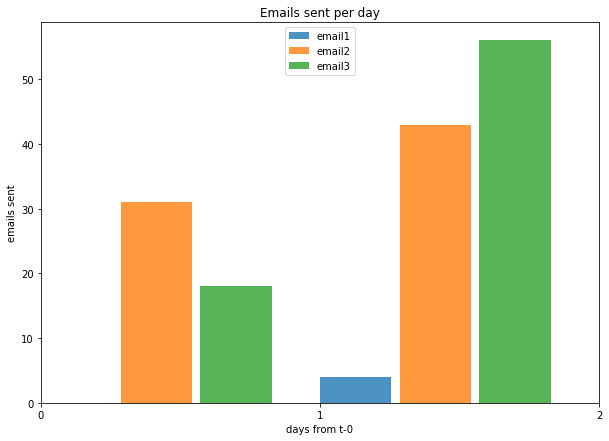

In [724]:
fig, ax = plt.subplots(figsize = (10,7))

# loop through and display all plots, adjust positioning
counter = -1/(num_bars+0.5)
for i in bar_show.columns[:-1]:
    counter += 1/(num_bars+0.5)
    ax.bar(bar_show.x+counter, bar_show[i], width=1/(1.3*num_bars), align='edge', label=i, alpha=0.8)

ax.set_title('Emails sent per day')
ax.set_ylabel('emails sent')
ax.set_xlabel('days from t-0')
ax.set_xticks(range(bar_show.shape[0]+1))
plt.legend();

total_sent = int(bar_show.sum().sum())
print(f'Total sent: {total_sent}')
print(f'Average per day: {total_sent/bar_show.shape[0]}')
for i in bar_show.columns[:-1]:
    emails_sent = int(bar_show[i].sum())
    print(f'{i}: {emails_sent}')

In [732]:
def bar_report():
    '''
    Loads database into DataFrame. Calculates number emails sent per day per email type.
    Output value_count statistics and plot
    '''
        
    df = pd.read_sql("SELECT * FROM customer_data", engine)
    report = df[['domain_name', 'create_date', 'domain_registrar_name', 'registrant_name',
                   'registrant_company', 'registrant_address', 'registrant_city',
                   'registrant_state', 'registrant_zip', 'registrant_country',
                   'registrant_email', 'registrant_phone', 'email0', 'email1', 
                   'email2', 'email3', 'email4', 'email5', 'email6', 'email7', 
                   'email8', 'email9', 'landing']]
    report = report[report[email_list].any(axis=1)]
    
    results = report.drop_duplicates(subset='registrant_email')[email_list][report[email_list].any(axis=1)].copy()
    
    for i in results.columns:
        results[i] = pd.to_datetime(results[i]).dt.date

    zero_date = pd.to_datetime(pd.Series(0))[0]
    results = results[results > zero_date]
    value_counter = [results[f'email{i}'].value_counts() for i in range(10)]
    bar_data = pd.concat(value_counter, axis=1).sort_index()
    bar_data['x'] = (bar_data.index - bar_data.index.min()).days
    bar_show = bar_data.dropna(how='all', axis=1)
    num_bars = bar_show.shape[1]-1
    
    fig, ax = plt.subplots(figsize = (10,7))

    counter = -1/(num_bars+0.5)
    for i in bar_show.columns[:-1]:
        counter += 1/(num_bars+0.5)
        ax.bar(bar_show.x+counter, bar_show[i], width=1/(1.3*num_bars), align='edge', label=i, alpha=0.8)

    ax.set_title('Emails / day')
    ax.set_ylabel('emails sent')
    ax.set_xlabel('days from t-0')
    ax.set_xticks(range(bar_show.shape[0]+1))
    plt.legend();

    total_sent = int(bar_show.sum().sum())
    print(f'Total sent: {total_sent}')
    print(f'Average per day: {total_sent/bar_show.shape[0]}')
    for i in bar_show.columns[:-1]:
        emails_sent = int(bar_show[i].sum())
        print(f'{i}: {emails_sent}')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  app.launch_new_instance()


Total sent: 397
Average per day: 132.33333333333334
email1: 4
email2: 197
email3: 193


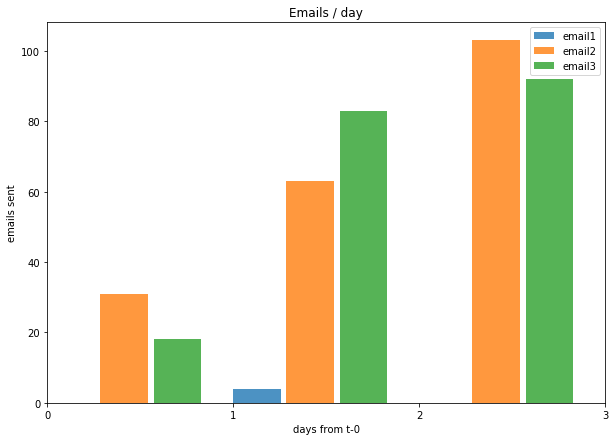

In [740]:
bar_report()

In [716]:
bar_show.shape

(2, 4)

In [67]:
email_address, SMTP, SMTP_port, username, pxxx, email_template = email_parameters(email_account_data[account], email_account_data[account]['email_file'], texas)

verbose=False

#s = smtplib.SMTP(SMTP)
s.connect(SMTP, SMTP_port)
s.ehlo()
s.login(username, pxxx)

send_counter = 0
not_landing_counter = 0
already_emailed = 0

email_content = load_email_content(f'{path}/email_templates/{email_template}')

customer_database = pd.read_csv(f'{path}/customer_database/customer_database.csv').drop('Unnamed: 0', axis=1)
emailed_already = set(customer_database.registrant_email.values)

bar = progressbar.ProgressBar()

for i,row in bar(texas.iterrows()):
    if row.landing != 1:
        not_landing_counter += 1
        continue
    
    if row.registrant_email in emailed_already:
        already_emailed +=1
        continue
    
    mail_merge = {'customer_name': row.registrant_name.split()[0],
                  'domain_name': row.domain_name,
                  'deadline': deadline(7)}  
    msg = customise_email(email_content, mail_merge)
    msg['To'] = 'gareth.egerton@gmail.com'
    s.sendmail(email_address, msg['To'], msg.as_string())

    send_counter +=1
    if verbose:
        print(send_counter)
        print(msg)
    texas.already.iloc[i] = 1
    row.aleady = 1

    texas[f'email_{email_template[5:6]}'] = dt.now()
    row[f'email_{email_template[5:6]}'] = dt.now()

    emailed_already.add(row.registrant_email)

    row = pd.DataFrame(row).transpose()

    row.to_csv(f'{path}/customer_database/customer_database.csv', mode='a', header=False)

print('')
print(f'Total messages sent: {send_counter} out of {texas.shape[0]} - {send_counter/texas.shape[0]}')
print(f'Non landing pages: {not_landing_counter}')
print(f'Already emailed: {already_emailed}')

| |#                                                 | 49 Elapsed Time: 0:00:00


Total messages sent: 0 out of 50 - 0.0
Non landing pages: 20
Already emailed: 30


# OLD Loop through url list and return GoDaddy landing pages

In [ ]:
bar = progressbar.ProgressBar()

url_results = []
for i in bar(texas.domain_name):
    url_results.append([i, godaddy_checker(i)])

### Save results

In [ ]:
results = pd.DataFrame(url_results)[1]
texas['landing'] = results.values*1
texas['already'] = 0 
texas['email_1'] = 0
texas['email_2'] = 0
texas['email_3'] = 0
texas = texas[['num', 'landing', 'already', 'email_1', 'email_2', 'email_3', 'domain_name', 
               'query_time', 'create_date', 'update_date',
               'expiry_date', 'domain_registrar_id', 'domain_registrar_name',
               'domain_registrar_whois', 'domain_registrar_url', 'registrant_name',
               'registrant_company', 'registrant_address', 'registrant_city',
               'registrant_state', 'registrant_zip', 'registrant_country',
               'registrant_email', 'registrant_phone', 'registrant_fax',
               'administrative_name', 'administrative_company',
               'administrative_address', 'administrative_city', 'administrative_state',
               'administrative_zip', 'administrative_country', 'administrative_email',
               'administrative_phone', 'administrative_fax', 'technical_name',
               'technical_company', 'technical_address', 'technical_city',
               'technical_state', 'technical_zip', 'technical_country',
               'technical_email', 'technical_phone', 'technical_fax', 'billing_name',
               'billing_company', 'billing_address', 'billing_city', 'billing_state',
               'billing_zip', 'billing_country', 'billing_email', 'billing_phone',
               'billing_fax', 'name_server_1', 'name_server_2', 'name_server_3',
               'name_server_4', 'domain_status_1', 'domain_status_2',
               'domain_status_3', 'domain_status_4']]

save_dates = f'{str(texas.create_date.max())[0:5]}_{texas.create_date.min()}'.replace('/', '-')
texas.to_csv(f'{path}/processed/{state}_{save_dates}.csv')

### Load multiple results

In [ ]:
texas = load_csvs(files_location=f'{path}/processed/*.csv').drop('Unnamed: 0', axis=1)

### Load single results

In [ ]:
texas = pd.read_csv(f'{path}/processed/{state}_{save_dates}.csv').drop('Unnamed: 0', axis=1)

### Setting up customer database to ensure no repeat sending

In [ ]:
customer_database0 = df[['registrant_name', 'registrant_email', 'registrant_company', 'registrant_address', 'registrant_city', 'registrant_state', 'registrant_zip', 'registrant_country', 'registrant_phone']].copy()

In [ ]:
customer_database = pd.DataFrame(columns=['registrant_name', 'registrant_email', 'registrant_company',
                                           'registrant_address', 'registrant_city', 'registrant_state',
                                           'registrant_zip', 'registrant_country', 'registrant_phone'])

In [ ]:
customer_database.to_csv(f'{path}/customer_database/{state}_{save_dates}.csv')

### create starting customer database !! DANGER !!

In [68]:
customer_database = pd.DataFrame(columns = ['num', 'landing', 'already', 'email_1', 'email_2', 'email_3', 'domain_name', 
               'query_time', 'create_date', 'update_date',
               'expiry_date', 'domain_registrar_id', 'domain_registrar_name',
               'domain_registrar_whois', 'domain_registrar_url', 'registrant_name',
               'registrant_company', 'registrant_address', 'registrant_city',
               'registrant_state', 'registrant_zip', 'registrant_country',
               'registrant_email', 'registrant_phone', 'registrant_fax',
               'administrative_name', 'administrative_company',
               'administrative_address', 'administrative_city', 'administrative_state',
               'administrative_zip', 'administrative_country', 'administrative_email',
               'administrative_phone', 'administrative_fax', 'technical_name',
               'technical_company', 'technical_address', 'technical_city',
               'technical_state', 'technical_zip', 'technical_country',
               'technical_email', 'technical_phone', 'technical_fax', 'billing_name',
               'billing_company', 'billing_address', 'billing_city', 'billing_state',
               'billing_zip', 'billing_country', 'billing_email', 'billing_phone',
               'billing_fax', 'name_server_1', 'name_server_2', 'name_server_3',
               'name_server_4', 'domain_status_1', 'domain_status_2',
               'domain_status_3', 'domain_status_4'])
customer_database.to_csv(f'{path}/customer_database/customer_database.csv')

### read customer database

In [35]:
customer_database = pd.read_csv(f'{path}/customer_database/customer_database.csv').drop('Unnamed: 0', axis=1)

## DRAFT Using amazon server

In [108]:
import smtplib

In [15]:
s = smtplib.SMTP('email-smtp.eu-west-1.amazonaws.com')

In [103]:
s = smtplib.SMTP(yesiprint['SMTP'])

In [141]:
s.connect(yesiprint['SMTP'], yesiprint['SMTP_port'])
s.ehlo()
s.login(yesiprint['username'], yesiprint['pxxx'])

email_template = 'email1.txt'
email = load_email_content(f'{path}/email_templates/{email_template}')

for i in range(3):
    mail_merge = {'customer_name': texas.registrant_name.iloc[i].split()[0],
                  'domain_name': texas.domain_name.iloc[i],
                  'deadline': deadline(7)}  
    msg = customise_email(email, mail_merge)
    msg['To'] = 'gareth.egerton@gmail.com'
    print(msg)
    s.sendmail(yesiprint['email'], msg['To'], msg.as_string())

Content-Type: text/plain; charset="us-ascii"
MIME-Version: 1.0
Content-Transfer-Encoding: 7bit
Subject: Godaddy holding page
From: godaddy@quizzard.com
To: gareth.egerton@gmail.com

Hi Darrell,
 
Thank you for joining the Godaddy family. The closest Godaddy Pro to your location is Websitecasa at Highway 6 and Beechnut. Anthony and the team are available to build a basic landing page at www.betterfuture4me.com at no cost if you call the office by 5th February. Additional services will attract a fee. Basic Websites start at $595 and can be ready in 10-business days,
 
If you would like to schedule an appointment to meet with your local Godaddy Pro call (832) 617-7959. We are open 9-5 Monday - Friday and 10 - 3 on Saturdays.
 
Websitecasa




Content-Type: text/plain; charset="us-ascii"
MIME-Version: 1.0
Content-Transfer-Encoding: 7bit
Subject: Godaddy holding page
From: godaddy@quizzard.com
To: gareth.egerton@gmail.com

Hi CloudPage,
 
Thank you for joining the Godaddy family. The closes

In [113]:
s.connect(yesiprint['SMTP'], yesiprint['SMTP_port'])
#s.starttls()
s.ehlo()
s.login(yesiprint['username'], yesiprint['pxxx'])

for i in range(2,3):
    msg = f'From: gareth.egerton@gmail.com\nTo: {email_list[i]}\nSubject: Your Godaddy holding page\n\nHi {texas.registrant_name.iloc[i].split()[0]},\n\nThank you for joining the Godaddy family. The closest Godaddy Pro to your location is Websitecasa at Highway 6 and Beechnut.\n\nAnthony and the team are available to build a basic landing page at www.{texas.domain_name.iloc[i]} at no cost if you call the office by {deadline(7)}. Additional services will attract a fee.\n\nBasic Websites start at $595 and can be ready in 10-business days. If you would like to schedule an appointment to meet with your local Godaddy Pro, call (832) 617-7959. \n\nWe are open 9-5 Monday - Friday and 10 - 3 on Saturdays.\n\nBest regards,\nWebsitecasa'#.encode("ascii", errors="ignore")
    print('')
    print(msg)
    s.sendmail(yesiprint['email'], email_list[i], msg)


From: gareth.egerton@gmail.com
To: gareth.egerton@gmail.com
Subject: Your Godaddy holding page

Hi Patrick,

Thank you for joining the Godaddy family. The closest Godaddy Pro to your location is Websitecasa at Highway 6 and Beechnut.

Anthony and the team are available to build a basic landing page at www.chrundletheband.com at no cost if you call the office by 4th February. Additional services will attract a fee.

Basic Websites start at $595 and can be ready in 10-business days. If you would like to schedule an appointment to meet with your local Godaddy Pro, call (832) 617-7959. 

We are open 9-5 Monday - Friday and 10 - 3 on Saturdays.

Best regards,
Websitecasa


In [134]:
for i in range(3):

    msg = f'From: mywebsitecasa@gmail.com>\nTo:{email_list[i]}\nSubject: Godaddy holding page\nHi {texas.registrant_name.iloc[i].split()[0]},\n\nThank you for joining the Godaddy family. The closest Godaddy Pro to your location is Websitecasa at Highway 6 and Beechnut.\n\nAnthony and the team are available to build a basic landing page on www.{texas.domain_name.iloc[i]} at no cost if you call the office by {deadline}. Additional services will attract a fee. \n\nBasic Websites start at $595 and can be ready in 10-business days. If you would like to schedule an appointment to meet with your local Godaddy Pro, call (832) 617-7959. \n\nWe are open 9-5 Monday - Friday and 10 - 3 on Saturdays.\n\nBest regards,\nWebsitecasa'
    print(msg)
    print('')

From: Websitecasa <mywebsitecasa@gmail.com>
To: gareth.egerton@gmail.com
Subject: Godaddy holding page
Hi Sandra,

Thank you for joining the Godaddy family. The closest Godaddy Pro to your location is Websitecasa at Highway 6 and Beechnut.

Anthony and the team are available to build a basic landing page on www.abilenebitcoin.info at no cost if you call the office by 28th January. Additional services will attract a fee. 

Basic Websites start at $595 and can be ready in 10-business days. If you would like to schedule an appointment to meet with your local Godaddy Pro, call (832) 617-7959. 

We are open 9-5 Monday - Friday and 10 - 3 on Saturdays.

Best regards,
Websitecasa

From: Websitecasa <mywebsitecasa@gmail.com>
To: gagazook@gmail.com
Subject: Godaddy holding page
Hi Trenton,

Thank you for joining the Godaddy family. The closest Godaddy Pro to your location is Websitecasa at Highway 6 and Beechnut.

Anthony and the team are available to build a basic landing page on www.adv.renta

# Testing Geocoding

In [23]:
Geocoder.geocode("4207 N Washington Ave, Douglas, AZ 85607", sensor='true').valid_address

GeocoderError: Error REQUEST_DENIED
Query: https://maps.google.com/maps/api/geocode/json?address=4207+N+Washington+Ave%2C+Douglas%2C+AZ+85607&sensor=true&bounds=&region=&language=&components=

In [8]:
path = 'godaddy/raw/'

In [10]:
df = pd.read_csv(path+'full-database01_03.csv')

In [11]:
df

,num,domain_name,query_time,create_date,update_date,expiry_date,domain_registrar_id,domain_registrar_name,domain_registrar_whois,domain_registrar_url,registrant_name,registrant_company,registrant_address,registrant_city,registrant_state,registrant_zip,registrant_country,registrant_email,registrant_phone,registrant_fax,administrative_name,administrative_company,administrative_address,administrative_city,administrative_state,administrative_zip,administrative_country,administrative_email,administrative_phone,administrative_fax,technical_name,technical_company,technical_address,technical_city,technical_state,technical_zip,technical_country,technical_email,technical_phone,technical_fax,billing_name,billing_company,billing_address,billing_city,billing_state,billing_zip,billing_country,billing_email,billing_phone,billing_fax,name_server_1,name_server_2,name_server_3,name_server_4,domain_status_1,domain_status_2,domain_status_3,domain_status_4
0,1,000000toffffff.com,2020-01-03 16:57:46,2020-01-01,NaN,2021-01-01,1068.0,"NameCheap, Inc.",whois.namecheap.com,http://www.namecheap.com,WhoisGuard Protected,"WhoisGuard, Inc.",P.O. Box 0823-03411,Panama,Panama,NaN,Panama,4d5b7bd40cf843939fe4f78745a28b45.protect@whois...,+507.8365503,+51.17057182,WhoisGuard Protected,"WhoisGuard, Inc.",P.O. Box 0823-03411,Panama,Panama,NaN,Panama,4d5b7bd40cf843939fe4f78745a28b45.protect@whois...,+507.8365503,+51.17057182,WhoisGuard Protected,"WhoisGuard, Inc.",P.O. Box 0823-03411,Panama,Panama,NaN,Panama,4d5b7bd40cf843939fe4f78745a28b45.protect@whois...,+507.8365503,+51.17057182,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,dns1.registrar-servers.com,dns2.registrar-servers.com,NaN,NaN,addPeriod,clientTransferProhibited,NaN,NaN
1,2,0001y6.com,2020-01-03 17:12:51,2020-01-02,2020-01-02,2021-01-02,146.0,"GoDaddy.com, LLC",whois.godaddy.com,http://registrar.godaddy.com,NaN,NaN,NaN,NaN,dsf6574,NaN,Hong Kong,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ns23.domaincontrol.com,ns24.domaincontrol.com,NaN,NaN,clientDeleteProhibited,clientRenewProhibited,clientTransferProhibited,clientUpdateProhibited
2,3,0008258.com,2020-01-03 16:18:52,2020-01-02,2020-01-02,2021-01-02,146.0,"GoDaddy.com, LLC",whois.godaddy.com,http://registrar.godaddy.com,NaN,NaN,NaN,NaN,dsf6574,NaN,Hong Kong,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ns23.domaincontrol.com,ns24.domaincontrol.com,NaN,NaN,clientDeleteProhibited,clientRenewProhibited,clientTransferProhibited,clientUpdateProhibited
3,4,000bian.com,2020-01-03 09:23:53,2020-01-03,2020-01-03,2021-01-03,1479.0,"Namesilo, LLC",whois.namesilo.com,http://www.namesilo.com,Domain Administrator,See PrivacyGuardian.org,1928 E. Highland Ave. Ste F104 PMB# 255,Phoenix,AZ,85016,United States,pw-5c98512c8861ebcd7e15b89dade4fd5a@privacygua...,+1.3478717726,NaN,Domain Administrator,See PrivacyGuardian.org,1928 E. Highland Ave. Ste F104 PMB# 255,Phoenix,AZ,85016,United States,pw-5c98512c8861ebcd7e15b89dade4fd5a@privacygua...,+1.3478717726,NaN,Domain Administrator,See PrivacyGuardian.org,1928 E. Highland Ave. Ste F104 PMB# 255,Phoenix,AZ,85016,United States,pw-5c98512c8861ebcd7e15b89dade4fd5a@privacygua...,+1.3478717726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ns1.dnsowl.com,ns2.dnsowl.com,ns3.dnsowl.com,NaN,clientTransferProhibited,NaN,NaN,NaN
4,5,000biao.com,2020-01-03 09:23:49,2020-01-03,2020-01-03,2021-01-03,1479.0,"Namesilo, LLC",whois.namesilo.com,http://www.namesilo.com,Domain Administrator,See PrivacyGuardian.org,1928 E. Highland Ave. Ste F104 PMB# 255,Phoenix,AZ,85016,United States,pw-a84824a5f77f7e2c92c8c00cf1af68b8@privacygua...,+1.3478717726,NaN,Domain Administrator,See PrivacyGuardian.org,1928 E. Highland Ave. Ste F104 PMB# 255,Phoenix,AZ,85016,United States,pw-a84824a5f77f7e2c92c8c00cf1af68b8@privacygua...,+1.3478717726,NaN,Domain Administrator,See PrivacyGuardian.org,1928 E.

In [12]:
state = 'Texas'
godaddy = df[df.domain_registrar_name.str.contains('GoDaddy', na=False)]
texas2 = godaddy[godaddy.technical_state == state].copy()

In [15]:
texas2

,num,domain_name,query_time,create_date,update_date,expiry_date,domain_registrar_id,domain_registrar_name,domain_registrar_whois,domain_registrar_url,registrant_name,registrant_company,registrant_address,registrant_city,registrant_state,registrant_zip,registrant_country,registrant_email,registrant_phone,registrant_fax,administrative_name,administrative_company,administrative_address,administrative_city,administrative_state,administrative_zip,administrative_country,administrative_email,administrative_phone,administrative_fax,technical_name,technical_company,technical_address,technical_city,technical_state,technical_zip,technical_country,technical_email,technical_phone,technical_fax,billing_name,billing_company,billing_address,billing_city,billing_state,billing_zip,billing_country,billing_email,billing_phone,billing_fax,name_server_1,name_server_2,name_server_3,name_server_4,domain_status_1,domain_status_2,domain_status_3,domain_status_4
3116,3117,4thofjulyboston.com,2020-01-03 16:47:06,2020-01-02,2020-01-02,2021-01-02,146.0,"GoDaddy.com, LLC",whois.godaddy.com,http://registrar.godaddy.com,Scott Petersen,Website Sales Co,3500 Tangle Brush Drive #117,The Woodlands,Texas,77381,United States,scottmotex@netscape.com,2812178626,NaN,Scott Petersen,Website Sales Co,3500 Tangle Brush Drive #117,The Woodlands,Texas,77381,United States,scottmotex@netscape.com,2812178626,NaN,Scott Petersen,Website Sales Co,3500 Tangle Brush Drive #117,The Woodlands,Texas,77381,United States,scottmotex@netscape.com,2812178626,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ns23.domaincontrol.com,ns24.domaincontrol.com,NaN,NaN,clientDeleteProhibited,clientRenewProhibited,clientTransferProhibited,clientUpdateProhibited
8338,8339,alifealongtheway.com,2020-01-03 17:42:03,2020-01-01,2020-01-01,2021-01-01,146.0,"GoDaddy.com, LLC",whois.godaddy.com,http://registrar.godaddy.com,Michael Jarrett,THE TRINITY MISSION,3008 Whitetail Dr,Weslaco,Texas,78596,United States,mtjarrett@michaeljarrett.com,+1.5124262228,NaN,Michael Jarrett,THE TRINITY MISSION,3008 Whitetail Dr,Weslaco,Texas,78596,United States,mtjarrett@michaeljarrett.com,+1.5124262228,NaN,Michael Jarrett,THE TRINITY MISSION,3008 Whitetail Dr,Weslaco,Texas,78596,United States,mtjarrett@michaeljarrett.com,+1.5124262228,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ns23.domaincontrol.com,ns24.domaincontrol.com,NaN,NaN,clientDeleteProhibited,clientRenewProhibited,clientTransferProhibited,clientUpdateProhibited
10735,10736,artfecta.com,2020-01-03 15:45:51,2020-01-01,2020-01-01,2021-01-01,146.0,"GoDaddy.com, LLC",whois.godaddy.com,http://registrar.godaddy.com,Justin Liles,Curematics,7951 Colllin McKinney Parkway #3100,McKinney,Texas,75070,United States,jl@justinliles.com,+1.8563250975,NaN,Justin Liles,Curematics,7951 Colllin McKinney Parkway #3100,McKinney,Texas,75070,United States,jl@justinliles.com,+1.8563250975,NaN,Justin Liles,Curematics,7951 Colllin McKinney Parkway #3100,McKinney,Texas,75070,United States,jl@justinliles.com,+1.8563250975,NaN,Justin Liles,Curematics,7951 Colllin McKinney Parkway #3100,McKinney,Texas,75070,United States,jl@justinliles.com,+1.8563250975,NaN,ns23.domaincontrol.com,ns24.domaincontrol.com,NaN,NaN,clientDeleteProhibited,clientRenewProhibited,clientTransferProhibited,clientUpdateProhibited
15762,15763,bnbcoaching.com,2020-01-03 16:32:37,2020-01-02,2020-01-02,2021-01-02,146.0,"GoDaddy.com, LLC",whois.godaddy.com,http://registrar.godaddy.com,Antonio San Roman,Amigo,PO Box 972115,El Paso,Texas,79997,United States,tonysanroman@gmail.com,19157721500,NaN,Antonio San Roman,Amigo,PO Box 972115,El Paso,Texas,79997,United States,tonysanroman@gmail.com,19157721500,NaN,Antonio San Roman,Amigo,PO Box 972115,El Paso,Texas,79997,United States,tonysanroman@gmail.com,19157721500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ns23.domaincontrol.com,ns24.domaincontrol.com,NaN,NaN,clientDeleteProhibited,clientRenewProhibited,clientTransferProhibited,clientUpdateProhibited
26877,26878,diablocarrentals.com,2020-01-0